## BACA TEKS

In [1]:
import pandas as pd

# baca file baris demi baris
with open("whatsapp_chat.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

# langsung bikin DataFrame dari list of lines
df_raw = pd.DataFrame(lines, columns=["RawLine"])

print("Total baris:", len(df_raw))
print(df_raw.head(10))


Total baris: 56704
                                             RawLine
0            02/01/25, 8:27 pm - via: btw pos brp?\n
1             02/01/25, 8:29 pm - Puguh UKKI'23: 4\n
2  02/01/25, 8:31 pm - Puguh UKKI'23: sampeyan ju...
3                  02/01/25, 8:33 pm - via: pgpaud\n
4         02/01/25, 8:33 pm - via: smn jurusan op?\n
5  02/01/25, 8:34 pm - Puguh UKKI'23: Sains data ...
6                    02/01/25, 8:36 pm - via: wihh\n
7   02/01/25, 8:36 pm - Puguh UKKI'23: Pgpaud fip?\n
8                   02/01/25, 8:36 pm - via: benar\n
9          02/01/25, 8:36 pm - Puguh UKKI'23: Hmmm\n


## PISAHKAN KOLOM 

In [2]:
import re
rows = []
current = None  # untuk menyimpan pesan aktif

# regex sederhana: baris yang dimulai dengan tanggal/jam
pattern = re.compile(r"^\d{1,2}/\d{1,2}/\d{2,4},\s*\d{1,2}[:.]\d{2}(?:\s?[ap]m)? - .+?: ")

for line in df_raw["RawLine"]:
    line = line.strip()
    if pattern.match(line):  
        # simpan pesan lama
        if current:
            rows.append(current)
        # pisahkan datetime dan isi
        date_time, rest = line.split(" - ", 1)
        if ": " in rest:
            name, chat = rest.split(": ", 1)
        else:
            name, chat = rest, ""
        current = [date_time, name.strip(), chat.strip()]
    else:
        # ini baris lanjutan → gabungkan ke chat sebelumnya
        if current:
            current[2] += " " + line

# jangan lupa simpan pesan terakhir
if current:
    rows.append(current)

df = pd.DataFrame(rows, columns=["TanggalJam", "Nama", "Chat"])

# ubah ke datetime
df["Datetime"] = pd.to_datetime(df["TanggalJam"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["Datetime"]).set_index("Datetime").sort_index()

print(df.head(10))


C:\Users\puguh\AppData\Local\Temp\ipykernel_14444\626020823.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Datetime"] = pd.to_datetime(df["TanggalJam"], dayfirst=True, errors="coerce")


                            TanggalJam           Nama                  Chat
Datetime                                                                   
2025-01-02 20:27:00  02/01/25, 8:27 pm            via          btw pos brp?
2025-01-02 20:29:00  02/01/25, 8:29 pm  Puguh UKKI'23                     4
2025-01-02 20:31:00  02/01/25, 8:31 pm  Puguh UKKI'23  sampeyan juursan apa
2025-01-02 20:33:00  02/01/25, 8:33 pm            via                pgpaud
2025-01-02 20:33:00  02/01/25, 8:33 pm            via       smn jurusan op?
2025-01-02 20:34:00  02/01/25, 8:34 pm  Puguh UKKI'23      Sains data fmipa
2025-01-02 20:36:00  02/01/25, 8:36 pm            via                  wihh
2025-01-02 20:36:00  02/01/25, 8:36 pm  Puguh UKKI'23           Pgpaud fip?
2025-01-02 20:36:00  02/01/25, 8:36 pm            via                 benar
2025-01-02 20:36:00  02/01/25, 8:36 pm  Puguh UKKI'23                  Hmmm


## UBAH DATETIME

In [3]:

df["Datetime"] = pd.to_datetime(df["TanggalJam"], dayfirst=True)

# set index biar siap untuk time series
df = df.set_index("Datetime").sort_index()

print(df.head())

C:\Users\puguh\AppData\Local\Temp\ipykernel_14444\4152168504.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Datetime"] = pd.to_datetime(df["TanggalJam"], dayfirst=True)


                            TanggalJam           Nama                  Chat
Datetime                                                                   
2025-01-02 20:27:00  02/01/25, 8:27 pm            via          btw pos brp?
2025-01-02 20:29:00  02/01/25, 8:29 pm  Puguh UKKI'23                     4
2025-01-02 20:31:00  02/01/25, 8:31 pm  Puguh UKKI'23  sampeyan juursan apa
2025-01-02 20:33:00  02/01/25, 8:33 pm            via                pgpaud
2025-01-02 20:33:00  02/01/25, 8:33 pm            via       smn jurusan op?


In [4]:
# drop kolom tanggal jam 
df = df.drop(columns=["TanggalJam"])

In [5]:
df.head()

,Nama,Chat
Datetime,,
2025-01-02 20:27:00,via,btw pos brp?
2025-01-02 20:29:00,Puguh UKKI'23,4
2025-01-02 20:31:00,Puguh UKKI'23,sampeyan juursan apa
2025-01-02 20:33:00,via,pgpaud
2025-01-02 20:33:00,via,smn jurusan op?


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54581 entries, 2025-01-02 20:27:00 to 2025-08-26 10:15:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Nama    54581 non-null  object
 1   Chat    54581 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


## PREPARATION

In [7]:
import string

# regex emoji
emoji_pattern = re.compile(
    "[" 
    "\U0001F600-\U0001F64F"
    "\U0001F300-\U0001F5FF"
    "\U0001F680-\U0001F6FF"
    "\U0001F1E0-\U0001F1FF"
    "\U00002700-\U000027BF"
    "\U0001F900-\U0001F9FF"
    "\U00002600-\U000026FF"
    "\U00002B00-\U00002BFF"
    "\U00002300-\U000023FF"
    "]+", flags=re.UNICODE
)

# regex link
url_pattern = re.compile(r"http\S+|www\.\S+")

def clean_text(text: str) -> str:
    text = str(text)
    text = url_pattern.sub("", text)  # hapus link
    text = emoji_pattern.sub("", text)  # hapus emoji
    text = text.translate(str.maketrans("", "", string.punctuation))  # hapus tanda baca
    text = re.sub(r"\s+", " ", text)  # rapikan whitespace jadi 1 spasi
    return text.strip()  # hilangkan spasi awal & akhir

# terapkan
df["Chat"] = df["Chat"].apply(clean_text)

# buang baris kosong
df = df[df["Chat"].ne("")]

print("Total pesan setelah pembersihan:", len(df))
print(df.head(10))


Total pesan setelah pembersihan: 53452
                              Nama                  Chat
Datetime                                                
2025-01-02 20:27:00            via           btw pos brp
2025-01-02 20:29:00  Puguh UKKI'23                     4
2025-01-02 20:31:00  Puguh UKKI'23  sampeyan juursan apa
2025-01-02 20:33:00            via                pgpaud
2025-01-02 20:33:00            via        smn jurusan op
2025-01-02 20:34:00  Puguh UKKI'23      Sains data fmipa
2025-01-02 20:36:00            via                  wihh
2025-01-02 20:36:00  Puguh UKKI'23            Pgpaud fip
2025-01-02 20:36:00            via                 benar
2025-01-02 20:36:00  Puguh UKKI'23                  Hmmm


## analisis time

In [31]:
import plotly.express as px
import plotly.graph_objects as go

# jumlah chat per hari
daily_counts = df.resample("D").size().reset_index()
daily_counts.columns = ["Tanggal", "Jumlah Pesan"]

# cari max & min
max_row = daily_counts.loc[daily_counts["Jumlah Pesan"].idxmax()]
min_row = daily_counts.loc[daily_counts["Jumlah Pesan"].idxmin()]

# grafik dasar
fig = px.line(
    daily_counts,
    x="Tanggal",
    y="Jumlah Pesan",
    title="📊 Jumlah Chat per Hari (Interaktif)",
    markers=True
)

# titik max (❌ merah)
fig.add_trace(
    go.Scatter(
        x=[max_row["Tanggal"]],
        y=[max_row["Jumlah Pesan"]],
        mode="markers+text",
        marker=dict(symbol="x", size=14, color="red"),
        text=[f"Max: {max_row['Jumlah Pesan']}"],
        textposition="top center",
        name="Tertinggi"
    )
)

# titik min (❌ biru) — hanya kalau min >= 10 biar tidak bentrok dengan xmin
if min_row["Jumlah Pesan"] >= 10:
    fig.add_trace(
        go.Scatter(
            x=[min_row["Tanggal"]],
            y=[min_row["Jumlah Pesan"]],
            mode="markers+text",
            marker=dict(symbol="x", size=14, color="blue"),
            text=[f"Min: {min_row['Jumlah Pesan']}"],
            textposition="bottom center",
            name="Terendah"
        )
    )

# titik dengan chat < 10 (❌ orange)
low_rows = daily_counts[daily_counts["Jumlah Pesan"] < 10]
if not low_rows.empty:
    fig.add_trace(
        go.Scatter(
            x=low_rows["Tanggal"],
            y=low_rows["Jumlah Pesan"],
            mode="markers+text",
            marker=dict(symbol="x", size=10, color="orange"),
            text=["xmin"]*len(low_rows),
            textposition="bottom center",
            name="Kurang dari 10"
        )
    )

fig.show()


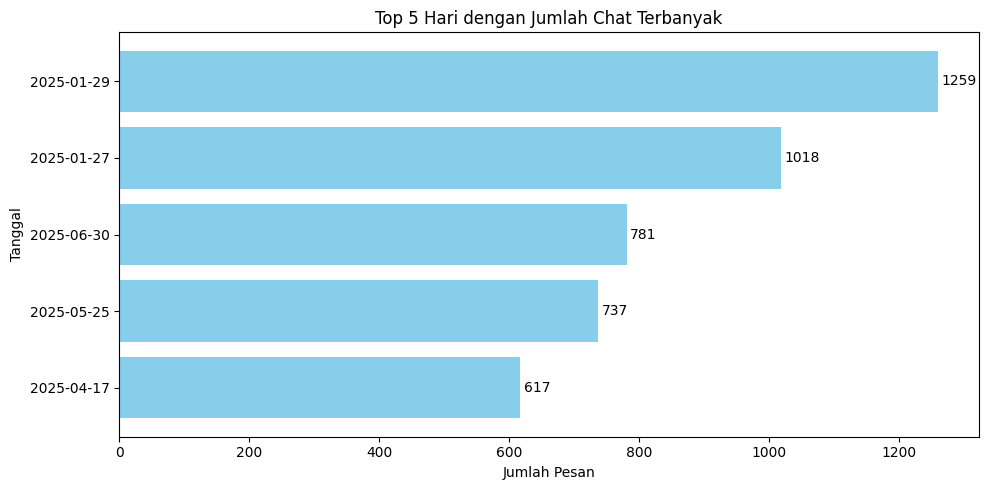

In [33]:
daily_counts = df.resample("D").size().reset_index()
daily_counts.columns = ["Tanggal", "Jumlah Pesan"]

# ambil 5 tanggal dengan chat terbanyak
top5_max = daily_counts.nlargest(5, "Jumlah Pesan").sort_values("Jumlah Pesan", ascending=True)

# plot bar horizontal
plt.figure(figsize=(10,5))
plt.barh(top5_max["Tanggal"].astype(str), top5_max["Jumlah Pesan"], color="skyblue")
plt.title("Top 5 Hari dengan Jumlah Chat Terbanyak")
plt.xlabel("Jumlah Pesan")
plt.ylabel("Tanggal")

# tampilkan nilai di ujung batang
for i, (val, tanggal) in enumerate(zip(top5_max["Jumlah Pesan"], top5_max["Tanggal"].astype(str))):
    plt.text(val+5, i, str(val), va="center")

plt.tight_layout()
plt.show()

# 📊 Insight Analisis Jumlah Chat per Hari

## 🔥 Temuan Utama
- Hari dengan **chat terbanyak**: **Akhir Januari 2025** →  **1.259 pesan**
- Hari dengan **chat sangat rendah (<10 pesan)**: tersebar di **akhir Februari, pertengahan Maret, hingga Agustus 2025**
- Sebagian besar hari berada di kisaran **100 – 500 chat**

---

## ⏰ Pola Aktivitas
- Aktivitas chat bersifat **fluktuatif** → ada lonjakan tinggi lalu penurunan drastis
- **Rentang normal**: 100–500 chat/hari
- **Beberapa hari sunyi** dengan chat <10 → menandakan jeda komunikasi (liburan, sibuk, atau jarang buka WA)

---
## Top Chat Tertinggi 
- 01/29 --> 1259 chat
- 01/27 --> 1018 chat
- 06/30 --> 781 chat
- 05/25 --> 737 chat
- 04/17 --> 617 chat

---

## 📅 Interpretasi
- Puncak chat di awal Februari kemungkinan karena **momen khusus**  
- Hari-hari dengan chat <10 menunjukkan **minim interaksi**  
- Secara keseluruhan pola chat menunjukkan hubungan yang **stabil**,  
  dengan periode **sangat aktif** dan periode **hening**

---

## 📝 Kesimpulan
Interaksi chat berlangsung **konsisten** dengan intensitas normal harian cukup tinggi.  
Namun, ada momen-momen spesifik yang memunculkan **ledakan komunikasi**  
dan juga hari-hari tertentu yang hampir **tanpa percakapan**. 

## Kira-kira percakapan menarik apa yang sudah dibahas?


In [29]:
# cari baris dengan jumlah pesan terbanyak
max_row = daily_counts.loc[daily_counts["Jumlah Pesan"].idxmax()]

# cari baris dengan jumlah pesan paling sedikit
min_row = daily_counts.loc[daily_counts["Jumlah Pesan"].idxmin()]

print("📌 Hari dengan chat terbanyak:")
print("Tanggal:", max_row["Tanggal"], "| Jumlah Pesan:", max_row["Jumlah Pesan"])

print("\n📌 Hari dengan chat paling sedikit:")
print("Tanggal:", min_row["Tanggal"], "| Jumlah Pesan:", min_row["Jumlah Pesan"])


📌 Hari dengan chat terbanyak:
Tanggal: 2025-01-29 00:00:00 | Jumlah Pesan: 1259

📌 Hari dengan chat paling sedikit:
Tanggal: 2025-02-18 00:00:00 | Jumlah Pesan: 0


In [24]:
# tanggal awal dan akhir
start_date = df.index.min()
end_date   = df.index.max()

# selisih
duration = end_date - start_date

print("Chat dimulai :", start_date)
print("Chat terakhir:", end_date)
print("Rentang waktu:", duration)
print("Dalam hari  :", duration.days, "hari")
print("Dalam bulan ~:", round(duration.days/30, 1), "bulan")


Chat dimulai : 2025-01-02 20:27:00
Chat terakhir: 2025-08-26 10:15:00
Rentang waktu: 235 days 13:48:00
Dalam hari  : 235 hari
Dalam bulan ~: 7.8 bulan


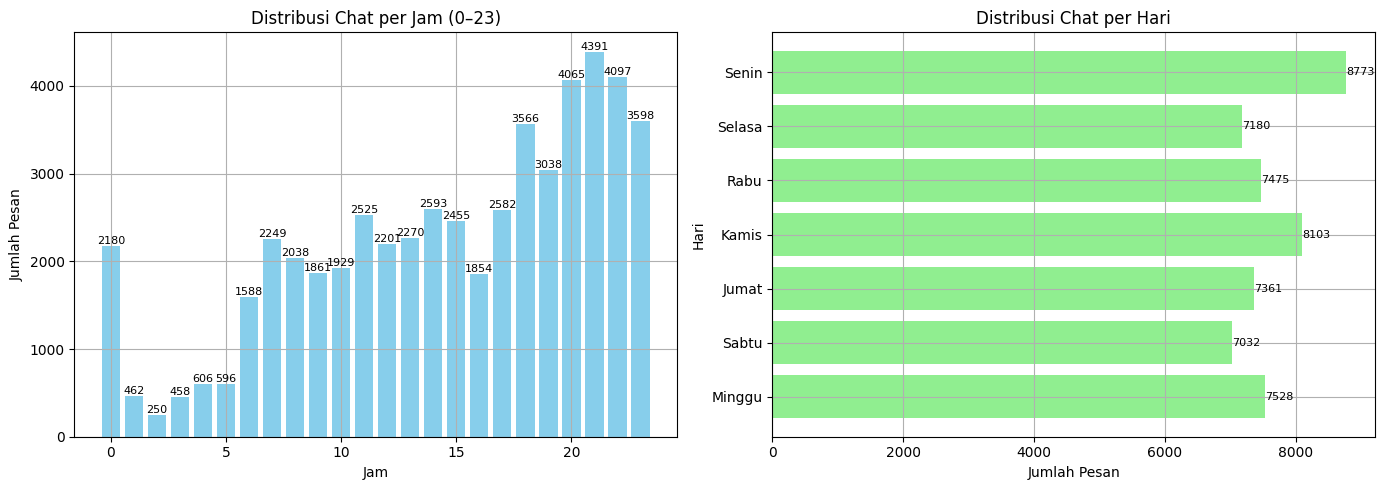

Jam tersibuk : 21 dengan 4391 pesan
Hari tersibuk: Senin dengan 8773 pesan


In [19]:
import matplotlib.pyplot as plt

# === Distribusi per jam ===
per_hour = df.groupby(df.index.hour).size()

# === Distribusi per hari ===
per_dayofweek = df.groupby(df.index.dayofweek).size()
day_map = {0:"Senin", 1:"Selasa", 2:"Rabu", 3:"Kamis", 4:"Jumat", 5:"Sabtu", 6:"Minggu"}
per_dayofweek.index = per_dayofweek.index.map(day_map)

# === Plot berdampingan ===
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# kiri: distribusi jam (bar + label)
bars1 = axes[0].bar(per_hour.index, per_hour.values, color="skyblue")
axes[0].set_title("Distribusi Chat per Jam (0–23)")
axes[0].set_xlabel("Jam")
axes[0].set_ylabel("Jumlah Pesan")
axes[0].grid(True)

# tambahkan label di atas batang
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height, str(height),
                 ha="center", va="bottom", fontsize=8)

# kanan: distribusi hari (bar horizontal + label)
bars2 = axes[1].barh(per_dayofweek.index[::-1], per_dayofweek.values[::-1], color="lightgreen")
axes[1].set_title("Distribusi Chat per Hari")
axes[1].set_xlabel("Jumlah Pesan")
axes[1].set_ylabel("Hari")
axes[1].grid(True)

# tambahkan label di ujung batang
for bar in bars2:
    width = bar.get_width()
    axes[1].text(width + 3, bar.get_y() + bar.get_height()/2, str(width),
                 ha="left", va="center", fontsize=8)

plt.tight_layout()
plt.show()

print("Jam tersibuk :", per_hour.idxmax(), "dengan", per_hour.max(), "pesan")
print("Hari tersibuk:", per_dayofweek.idxmax(), "dengan", per_dayofweek.max(), "pesan")


In [27]:
import plotly.figure_factory as ff
import numpy as np

# pivot data hari x jam
heatmap_data = df.groupby([df.index.dayofweek, df.index.hour]).size().unstack(fill_value=0)

# mapping hari
day_map = {0:"Senin", 1:"Selasa", 2:"Rabu", 3:"Kamis", 4:"Jumat", 5:"Sabtu", 6:"Minggu"}
heatmap_data.index = heatmap_data.index.map(day_map)

# buat annotated heatmap
fig = ff.create_annotated_heatmap(
    z=heatmap_data.values,
    x=[str(h) for h in heatmap_data.columns],  # jam
    y=list(heatmap_data.index),                # hari
    annotation_text=heatmap_data.values,       # angka dalam kotak
    colorscale="YlGnBu",
    showscale=True
)

fig.update_layout(
    title="Heatmap Interaktif Jumlah Chat per Hari dan Jam",
    xaxis_title="Jam (0-23)",
    yaxis_title="Hari"
)

fig.show()

# 📊 Analisis Intensitas Chat (Hari × Jam)

## 🔥 Ringkasan Utama
- Intensitas Chat **tersibuk**: 🕘 **Jam 21.00 WIB** pada **hari Senin**
- Intensitas Chat **paling jarang**: 🌙 **Jam 03.00 WIB** pada **hari Sabtu**

---

## ⏰ Analisis Berdasarkan Jam
- **Puncak aktivitas**: **20.00 – 22.00 WIB**
  - Terutama **Jumat malam** → 🚀 **892 chat pada jam 21.00**
- **Interpretasi**: Percakapan memuncak di malam hari, yaitu waktu pribadi setelah aktivitas utama selesai.

---

## 📅 Analisis Berdasarkan Hari
- **Hari paling aktif**: **Senin dan Jumat**
  - 📌 Senin malam → konsisten tinggi (646–688 chat)
  - 📌 Jumat malam → titik tertinggi mingguan (842–892 chat)
- **Hari paling sepi**: 💤 **Sabtu**, jumlah chat lebih rendah dibanding weekdays

---

## 🌙 Analisis Jam Sepi (Dini Hari)
- Rentang **01.00 – 05.00 WIB** → hampir tidak ada percakapan di semua hari
- 😴 Hal ini wajar karena merupakan jam tidur

---

## 📈 Pola Umum
- Aktivitas mulai naik sekitar **07.00–08.00 WIB** dan stabil sepanjang siang
- Lonjakan besar terjadi di **malam (18.00–22.00 WIB)**
- **Weekend (Sabtu–Minggu)** tetap aktif, tapi tidak setinggi Senin atau Jumat

---

### 📝 Kesimpulan
Komunikasi berlangsung rutin dan konsisten, dengan intensitas tertinggi di malam hari.  
💡 Ini menunjukkan percakapan bersifat **personal** dan bukan hanya sekadar formal.

## Pertanyaanya apakah chat tersebut membahas kegiatan di hari kerja dibandingkan liburan?


## Analisis partisipan 

Nama
Puguh UKKI'23    27450
via              26002
Name: count, dtype: int64


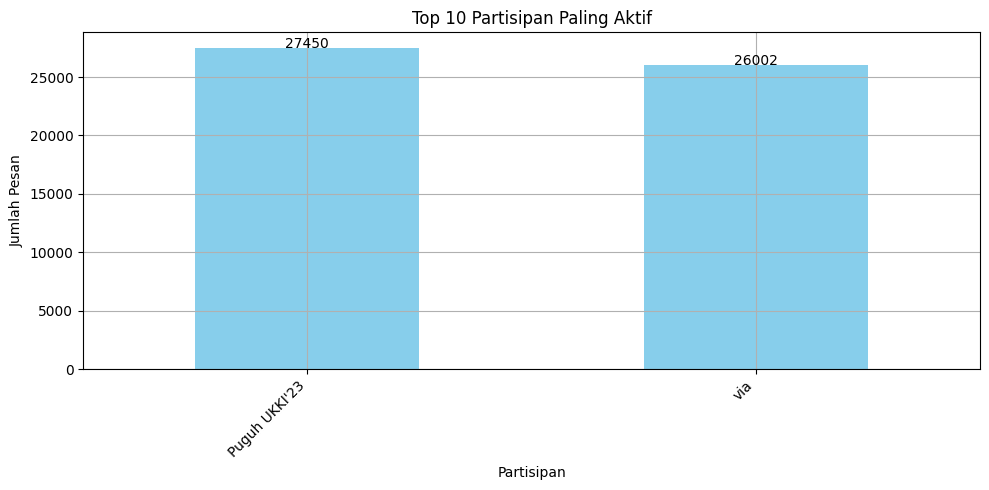

In [34]:

# hitung jumlah chat per partisipan
partisipan_counts = df["Nama"].value_counts()

print(partisipan_counts)

# plot top 10 partisipan
top10 = partisipan_counts.head(10)

plt.figure(figsize=(10,5))
top10.plot(kind="bar", color="skyblue", grid=True, title="Top 10 Partisipan Paling Aktif")
plt.ylabel("Jumlah Pesan")
plt.xlabel("Partisipan")
plt.xticks(rotation=45, ha="right")

# tambahkan angka di atas batang
for i, val in enumerate(top10.values):
    plt.text(i, val + 5, str(val), ha="center")

plt.tight_layout()
plt.show()


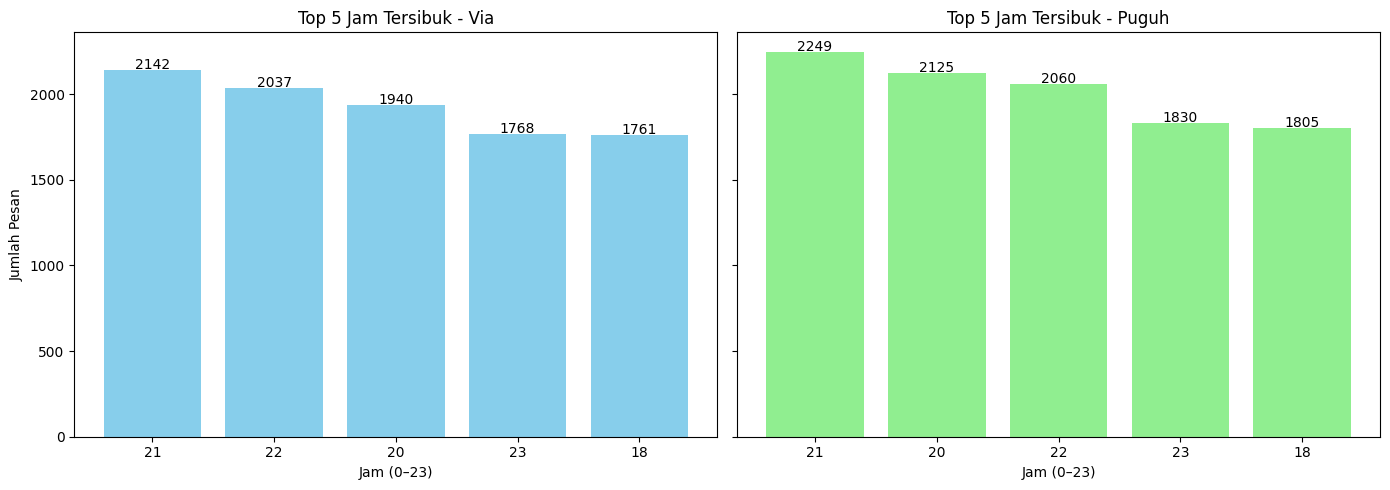

In [39]:
import matplotlib.pyplot as plt

# hitung jumlah chat per Nama x Jam
nama_jam = df.groupby([df["Nama"], df.index.hour]).size().reset_index(name="Jumlah")
nama_jam.columns = ["Nama", "Jam", "Jumlah"]   # pastikan kolom jadi jelas

# ambil top 5 jam tersibuk untuk setiap nama
top5_via = nama_jam[nama_jam["Nama"]=="via"].nlargest(5, "Jumlah")
top5_puguh = nama_jam[nama_jam["Nama"].str.contains("Puguh")].nlargest(5, "Jumlah")

# --- Plot berdampingan ---
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)

# Via
axes[0].bar(top5_via["Jam"].astype(str), top5_via["Jumlah"], color="skyblue")
axes[0].set_title("Top 5 Jam Tersibuk - Via")
axes[0].set_xlabel("Jam (0–23)")
axes[0].set_ylabel("Jumlah Pesan")
for i, (jam, val) in enumerate(zip(top5_via["Jam"], top5_via["Jumlah"])):
    axes[0].text(i, val+5, str(val), ha="center")

# Puguh
axes[1].bar(top5_puguh["Jam"].astype(str), top5_puguh["Jumlah"], color="lightgreen")
axes[1].set_title("Top 5 Jam Tersibuk - Puguh")
axes[1].set_xlabel("Jam (0–23)")
for i, (jam, val) in enumerate(zip(top5_puguh["Jam"], top5_puguh["Jumlah"])):
    axes[1].text(i, val+5, str(val), ha="center")

plt.tight_layout()
plt.show()


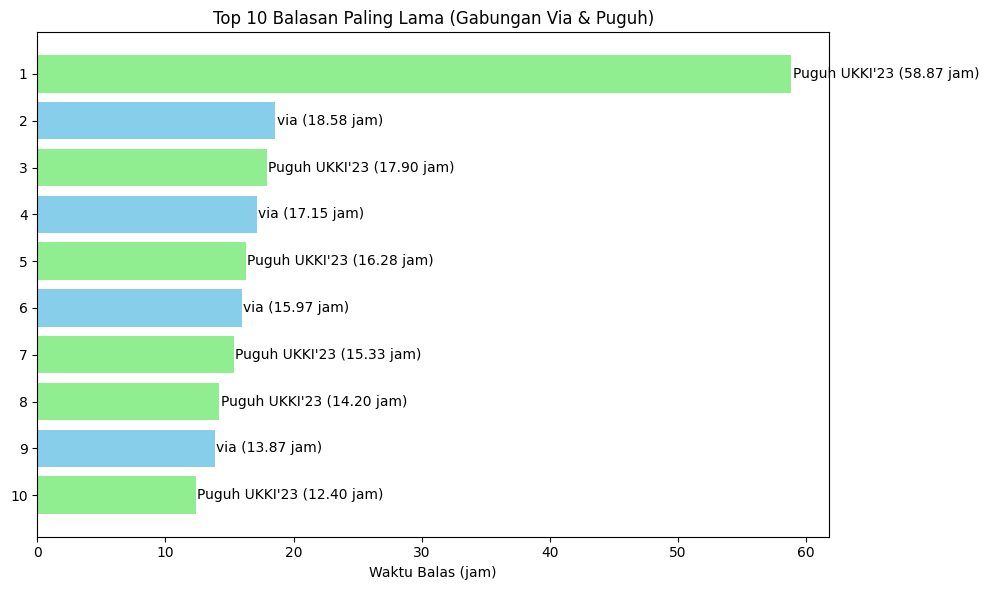

In [47]:
import matplotlib.pyplot as plt

# pastikan ada kolom Responder
df_response = df_response.copy()
df_response["Responder"] = df_response["Next_Nama"]

# ubah ke jam
df_response["Response_Hours"] = df_response["Response_Time"] / 60

# ambil 10 balasan terlama (gabungan via + puguh)
top10_all = df_response.nlargest(10, "Response_Hours")[["Responder", "Response_Hours"]]

# plot
plt.figure(figsize=(10,6))
bars = plt.barh(
    range(1, 11),
    top10_all["Response_Hours"],
    color=["skyblue" if "via" in name.lower() else "lightgreen" for name in top10_all["Responder"]]
)
plt.gca().invert_yaxis()
plt.yticks(range(1, 11), [f"{i}" for i in range(1, 11)])
plt.xlabel("Waktu Balas (jam)")
plt.title("Top 10 Balasan Paling Lama (Gabungan Via & Puguh)")

# tambahkan label jam + nama
for i, (val, nama) in enumerate(zip(top10_all["Response_Hours"], top10_all["Responder"]), start=1):
    plt.text(val+0.1, i, f"{nama} ({val:.2f} jam)", va="center")

plt.tight_layout()
plt.show()


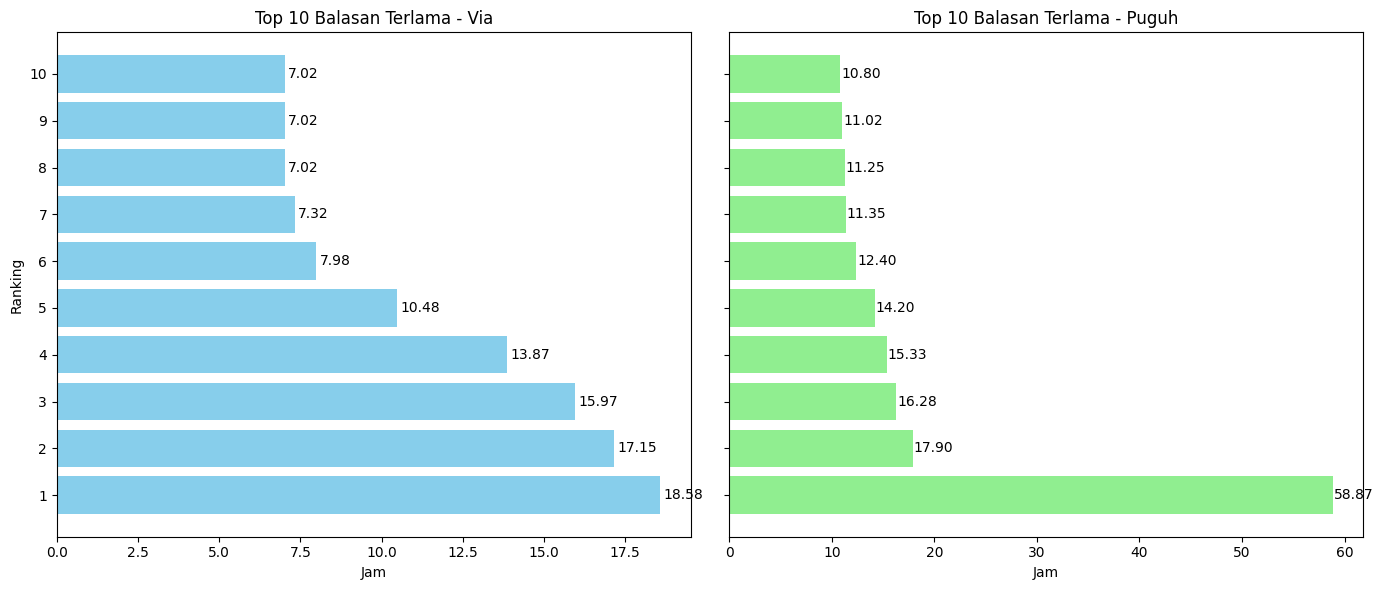

In [48]:
import matplotlib.pyplot as plt

# ubah ke jam
df_response = df_response.copy()
df_response["Response_Hours"] = df_response["Response_Time"] / 60

# --- Top 10 balasan terlama Via ---
top10_via = df_response[df_response["Next_Nama"]=="via"] \
    .nlargest(10, "Response_Hours")[["Nama","Chat","Next_Nama","Response_Hours"]]

# --- Top 10 balasan terlama Puguh ---
top10_puguh = df_response[df_response["Next_Nama"].str.contains("Puguh", na=False)] \
    .nlargest(10, "Response_Hours")[["Nama","Chat","Next_Nama","Response_Hours"]]

# --- Plot berdampingan ---
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# VIA
axes[0].barh(range(1, 11), top10_via["Response_Hours"], color="skyblue")
axes[0].set_yticks(range(1, 11))
axes[0].set_yticklabels(range(1, 11))
axes[0].invert_yaxis()
axes[0].set_title("Top 10 Balasan Terlama - Via")
axes[0].set_xlabel("Jam")
axes[0].set_ylabel("Ranking")
for i, val in enumerate(top10_via["Response_Hours"], start=1):
    axes[0].text(val+0.1, i, f"{val:.2f}", va="center")

# PUGUH
axes[1].barh(range(1, 11), top10_puguh["Response_Hours"], color="lightgreen")
axes[1].set_yticks(range(1, 11))
axes[1].set_yticklabels(range(1, 11))
axes[1].invert_yaxis()
axes[1].set_title("Top 10 Balasan Terlama - Puguh")
axes[1].set_xlabel("Jam")
for i, val in enumerate(top10_puguh["Response_Hours"], start=1):
    axes[1].text(val+0.1, i, f"{val:.2f}", va="center")

plt.tight_layout()
plt.show()


In [49]:
# hitung statistik respon per orang
stats = df_response.groupby("Next_Nama")["Response_Time"].agg(
    mean="mean",
    median="median",
    std="std",
    max="max",
    count="count"
)

# ubah menit ke jam biar lebih gampang dibaca
stats = stats / 60
stats = stats.rename(columns={
    "mean": "Rata-rata (jam)",
    "median": "Median (jam)",
    "std": "StdDev (jam)",
    "max": "Maks (jam)",
    "count": "Jumlah Balasan"
})

print(stats)


               Rata-rata (jam)  Median (jam)  StdDev (jam)  Maks (jam)  \
Next_Nama                                                                
Puguh UKKI'23         0.191160      0.016667      0.943175   58.866667   
via                   0.153598      0.016667      0.620852   18.583333   

               Jumlah Balasan  
Next_Nama                      
Puguh UKKI'23      218.550000  
via                218.533333  


# ⏱️ Analisis Konsistensi Balasan 

## 1. Kecepatan Balas
- **Via** sedikit lebih cepat: rata-rata **9 menit** dibanding **Puguh 11 menit**  
- **Median** sama persis: ± **1 menit** → keduanya biasanya balas cepat kalau sedang aktif  

---

## 2. Konsistensi
- **Via** lebih konsisten (StdDev = **0.62 jam**) dibanding **Puguh (0.94 jam**)  
- Artinya variasi balasan Puguh lebih lebar: kadang cepat, kadang lama sekali  
- **Via** lebih stabil dalam merespons  
- Dilihat dari plot jam, mereka juga konsisten **chating disaat jam malam 18.00-22.00**

---

## 3. Slow Respon Ekstrem
- **Puguh**: slow respon terlama **~59 jam (2,5 hari)**  
- **Via**: slow respon terlama **~18,6 jam**  
- 👉 Jika dilihat dari “ngilang paling lama”, **Puguh lebih sering slow respon**  
- Dilihat dari plot juga **Puguh telah mengalahkan Via dalam TOP 10 balasan paling lama** 

---

## 4. Volume Balasan
- Jumlah balasan hampir **sama persis**: ± **218 balasan** per orang  
- Komunikasi **seimbang**, tidak timpang  
- Jika dilihat dari plot paling banyak mengirim pesan adalah **Puguh** dibandingkan dengan Via dengan **selsih ± 100 pesan**

---

## 📝 Kesimpulan
- **Via** lebih **cepat & konsisten** dalam membalas  
- **Puguh** kadang balas cepat, tapi lebih sering punya **outlier slow respon** (hingga 2,5 hari)  
- Hubungan komunikasi keduanya bersifat **dua arah & seimbang**,  
  meski kecenderungan **slow respon lebih sering di sisi Puguh**. Namun, **Puguh paling banyak** mengirimkan chat kepada Via dan mereka **sering mengobrol di jam malam**.

  